### Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
from skimage.transform import resize
import matplotlib.pyplot as plt
import matplotlib.cm as cm


### Configurable parameters

In [2]:
# img_size = (299, 299)
img_size = (224, 224)

model_builder = keras.applications.xception.Xception
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

# model_builder = keras.applications.mobilenet.MobileNet
# preprocess_input = keras.applications.mobilenet.preprocess_input
# decode_predictions = keras.applications.mobilenet.decode_predictions


# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
# model.layers[-1].activation = None


In [3]:
## xception
last_conv_layer_name = "block14_sepconv2_act"
# last_conv_layer_name = "block13_sepconv2_act"

## mobile
# last_conv_layer_name = "conv_pw_13_relu"

model.summary()


Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [4]:
vis_layers = [i.name for i in model.layers]
# conv_layers = [vis_layer for vis_layer in vis_layers if vis_layer.endswith("act")] # xception
conv_layers = [vis_layer for vis_layer in vis_layers if vis_layer.endswith("relu")] # mobile
conv_layers

['conv1_relu',
 'conv_dw_1_relu',
 'conv_pw_1_relu',
 'conv_dw_2_relu',
 'conv_pw_2_relu',
 'conv_dw_3_relu',
 'conv_pw_3_relu',
 'conv_dw_4_relu',
 'conv_pw_4_relu',
 'conv_dw_5_relu',
 'conv_pw_5_relu',
 'conv_dw_6_relu',
 'conv_pw_6_relu',
 'conv_dw_7_relu',
 'conv_pw_7_relu',
 'conv_dw_8_relu',
 'conv_pw_8_relu',
 'conv_dw_9_relu',
 'conv_pw_9_relu',
 'conv_dw_10_relu',
 'conv_pw_10_relu',
 'conv_dw_11_relu',
 'conv_pw_11_relu',
 'conv_dw_12_relu',
 'conv_pw_12_relu',
 'conv_dw_13_relu',
 'conv_pw_13_relu']

### Grad-CAM algorithm

In [5]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def make_multi_gradcam_heatmap(img_array, model, conv_layers, pred_index=None):

    heatmaps = []
    for conv_layer in conv_layers:
        hm = make_gradcam_heatmap(img_array, model, conv_layer, pred_index=pred_index)
        hm = resize(hm, (149, 149))
        heatmaps.append(hm)

    heatmaps = np.array(heatmaps)
    heatmap = np.mean(heatmaps, axis = 0)
    heatmap = ((heatmap - heatmap.min())/heatmap.max())
    
    return heatmap


### Test drive

Predicted: [('n02504458', 'African_elephant', 0.9285755)]


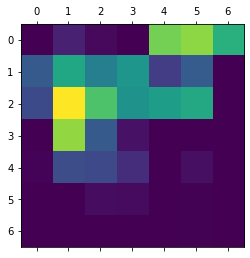

In [6]:
img_path = keras.utils.get_file(
    "african_elephant.jpg", "https://i.imgur.com/Bvro0YD.png"
)

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()


### Create a superimposed visualization

In [7]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=3):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmapb
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


### Let's try another image

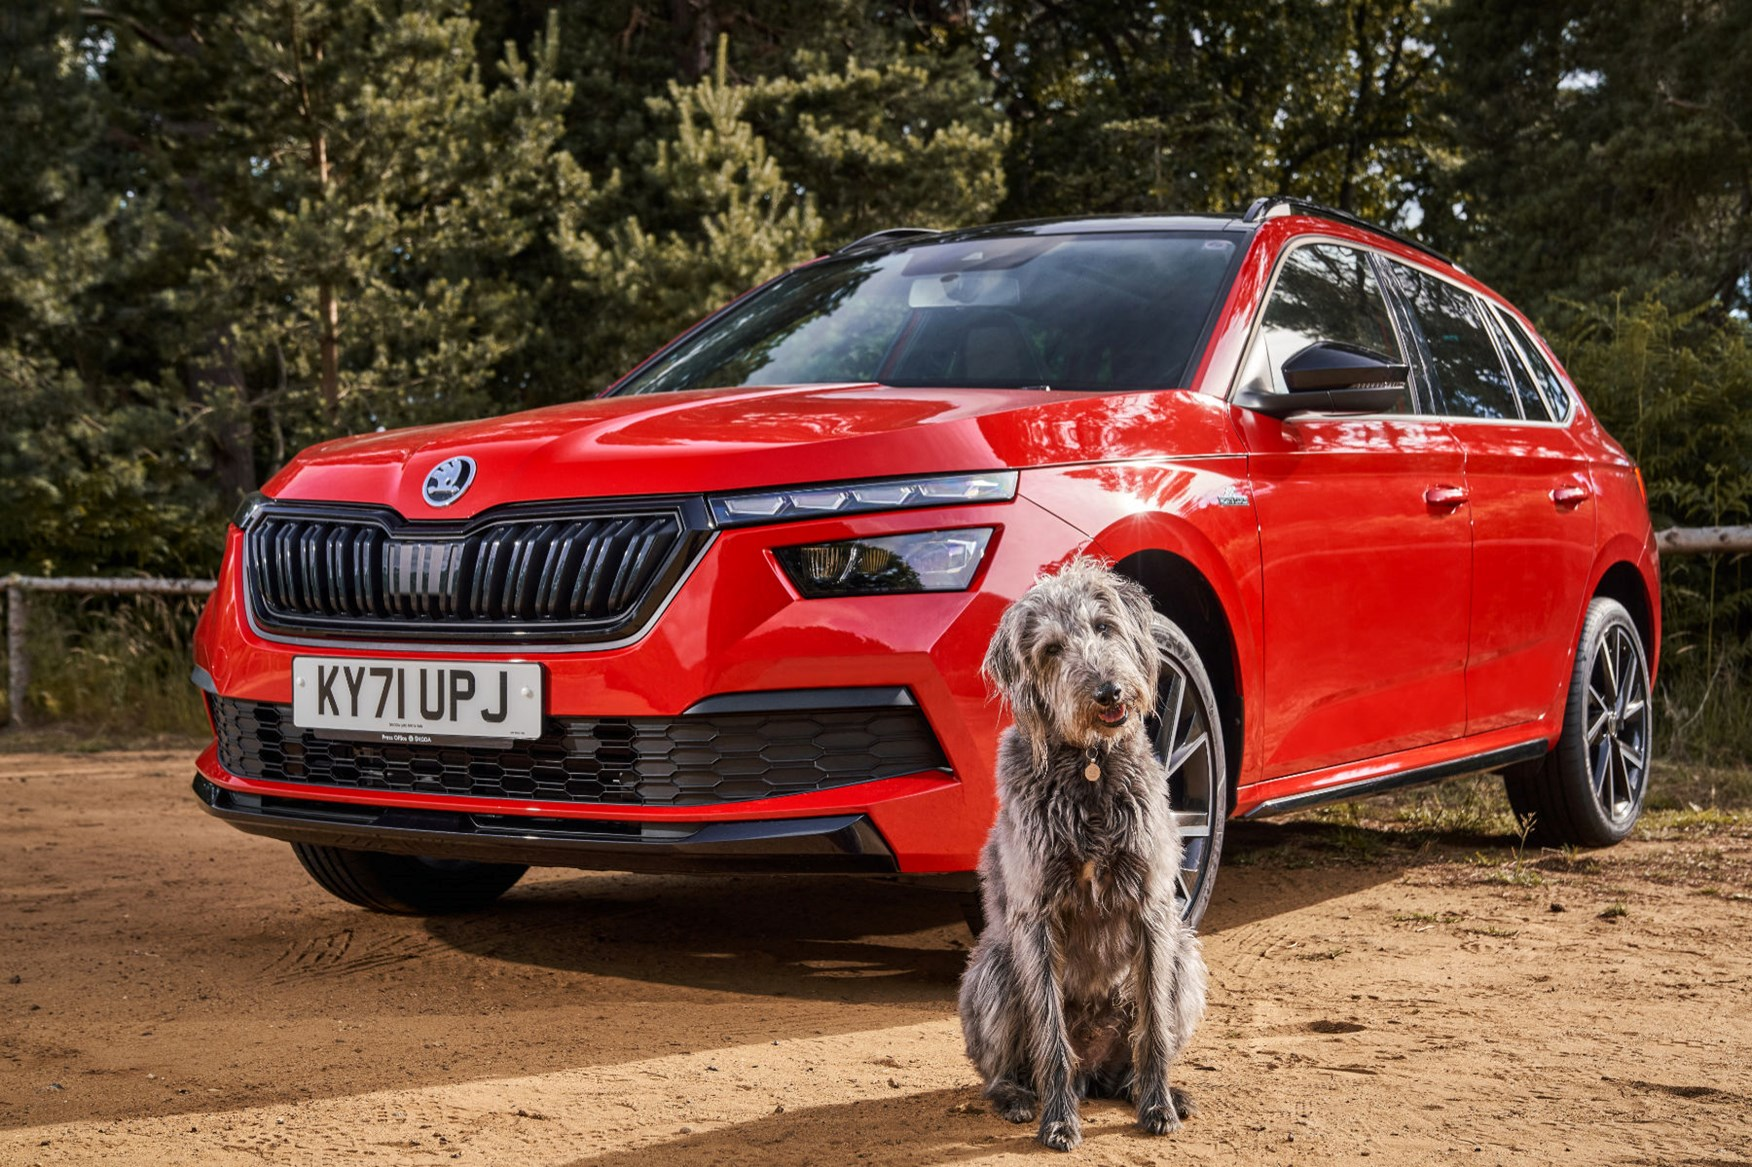

('n03459775', 'grille', 0.5918645) 581
('n02974003', 'car_wheel', 0.10815826) 479
('n04285008', 'sports_car', 0.095647156) 817
('n04037443', 'racer', 0.042743597) 751
('n02814533', 'beach_wagon', 0.040684674) 436
('n03770679', 'minivan', 0.031629253) 656
('n02930766', 'cab', 0.00870852) 468
('n03594945', 'jeep', 0.007826579) 609
('n02100236', 'German_short-haired_pointer', 0.007517637) 210
('n04146614', 'school_bus', 0.0067927144) 779
('n03670208', 'limousine', 0.004998743) 627
('n03930630', 'pickup', 0.0045654667) 717
('n03100240', 'convertible', 0.004356295) 511
('n03127747', 'crash_helmet', 0.0029831503) 518
('n02088632', 'bluetick', 0.0027543136) 164
('n03792782', 'mountain_bike', 0.0021725772) 671
('n04252077', 'snowmobile', 0.0017600344) 802
('n02101006', 'Gordon_setter', 0.0013621446) 214
('n02701002', 'ambulance', 0.0012984562) 407
('n02090721', 'Irish_wolfhound', 0.0011913128) 170


In [8]:
img_path = keras.utils.get_file(
    "car_and_dog_1.jpg",
    "https://parkers-images.bauersecure.com/gallery-image/wp-images/18896/1752x1168/bestcarfordog.jpg",
#     "https://img.autobytel.com/car-reviews/autobytel/130799-if-dogs-bought-cars/Dodge-Challenger-Siberian-Husky.jpg",
#     "https://images.unsplash.com/photo-1541764288931-4d6001e4714e?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwcm9maWxlLXBhZ2V8Mnx8fGVufDB8fHx8&w=1000&q=80",
#     "https://samadelstudios.files.wordpress.com/2018/01/img_7363-1.jpg",
#     "https://cross-currents.berkeley.edu/sites/default/files/styles/photo_essay_photo_main/public/photo-essays/photos/20120108-img_8418.jpg?itok=CAGVmjHa",
)

display(Image(img_path))

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the two top predicted classes are
preds = model.predict(img_array)
n = 20
predictions = decode_predictions(preds, top=n)[0]
indices = preds.argsort()[0, -n:][::-1]
for i, pred in enumerate(predictions):
    print(pred, indices[i])


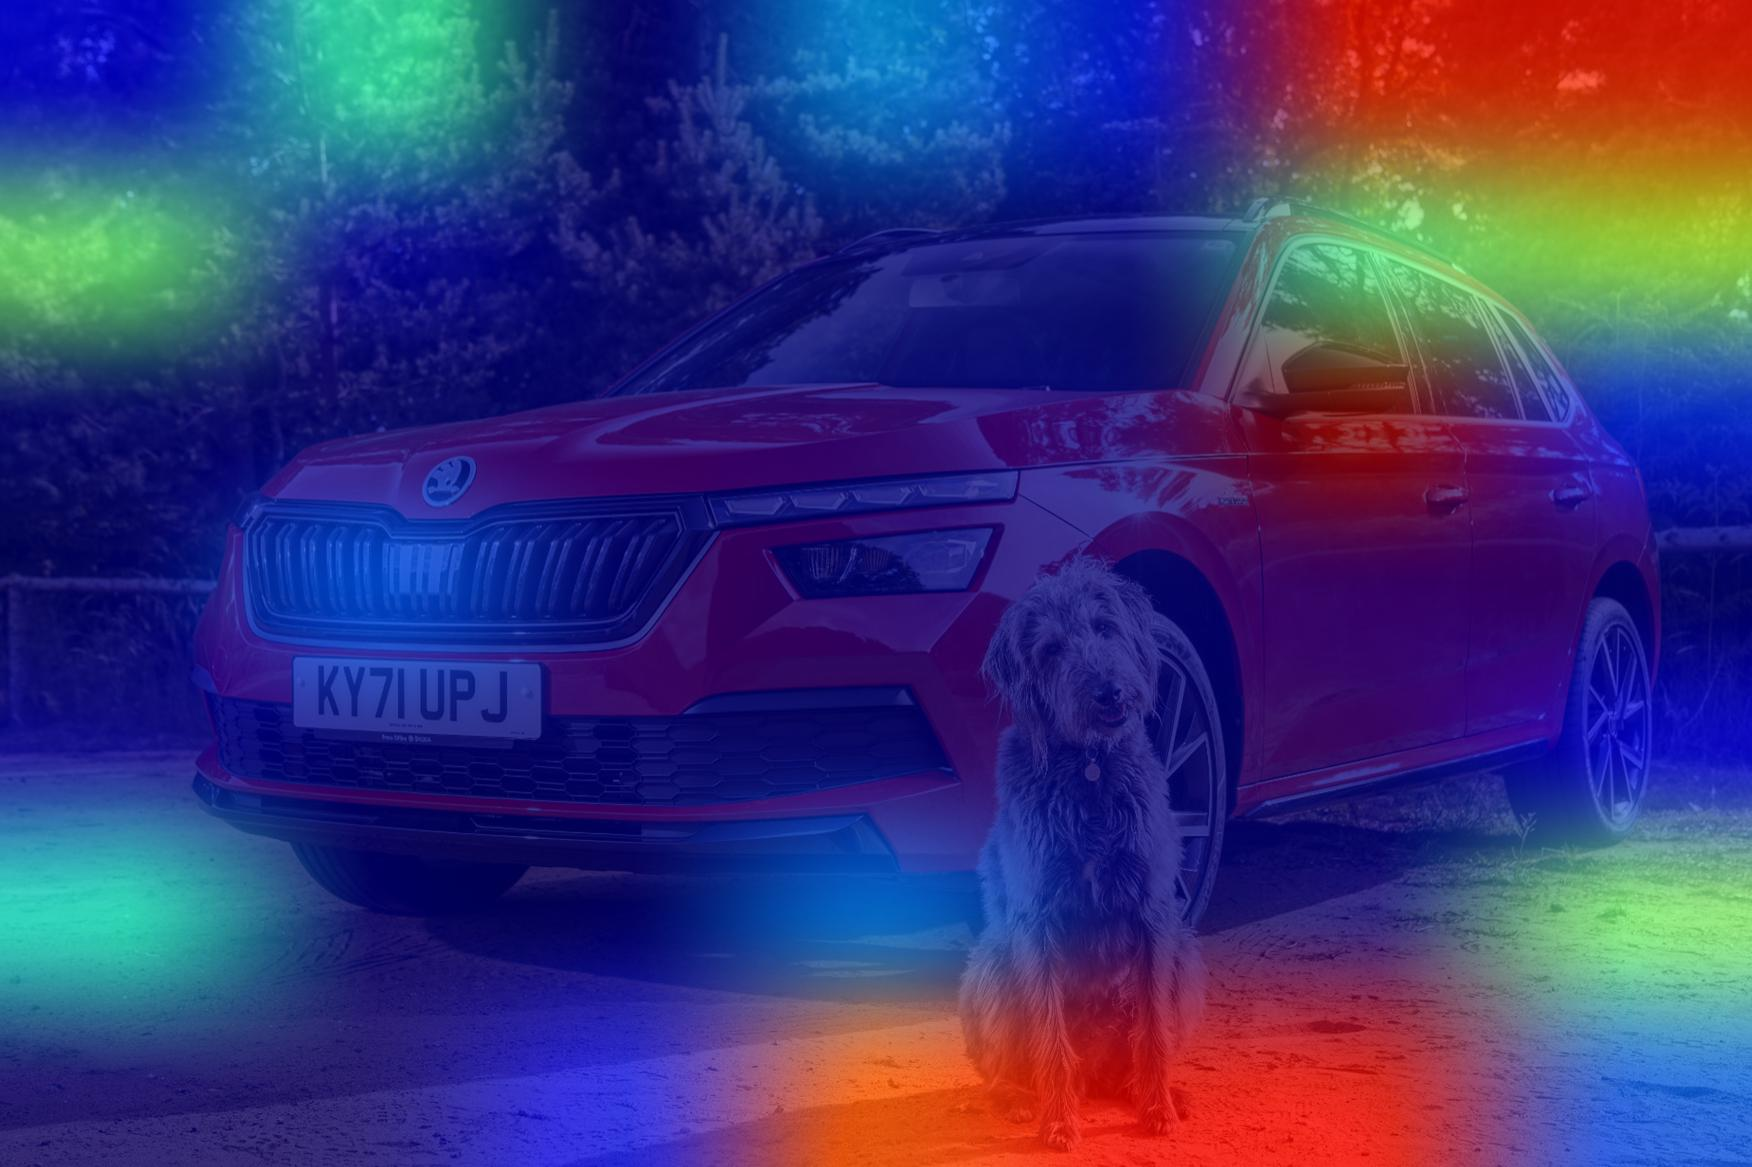

In [12]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=479)

save_and_display_gradcam(img_path, heatmap)


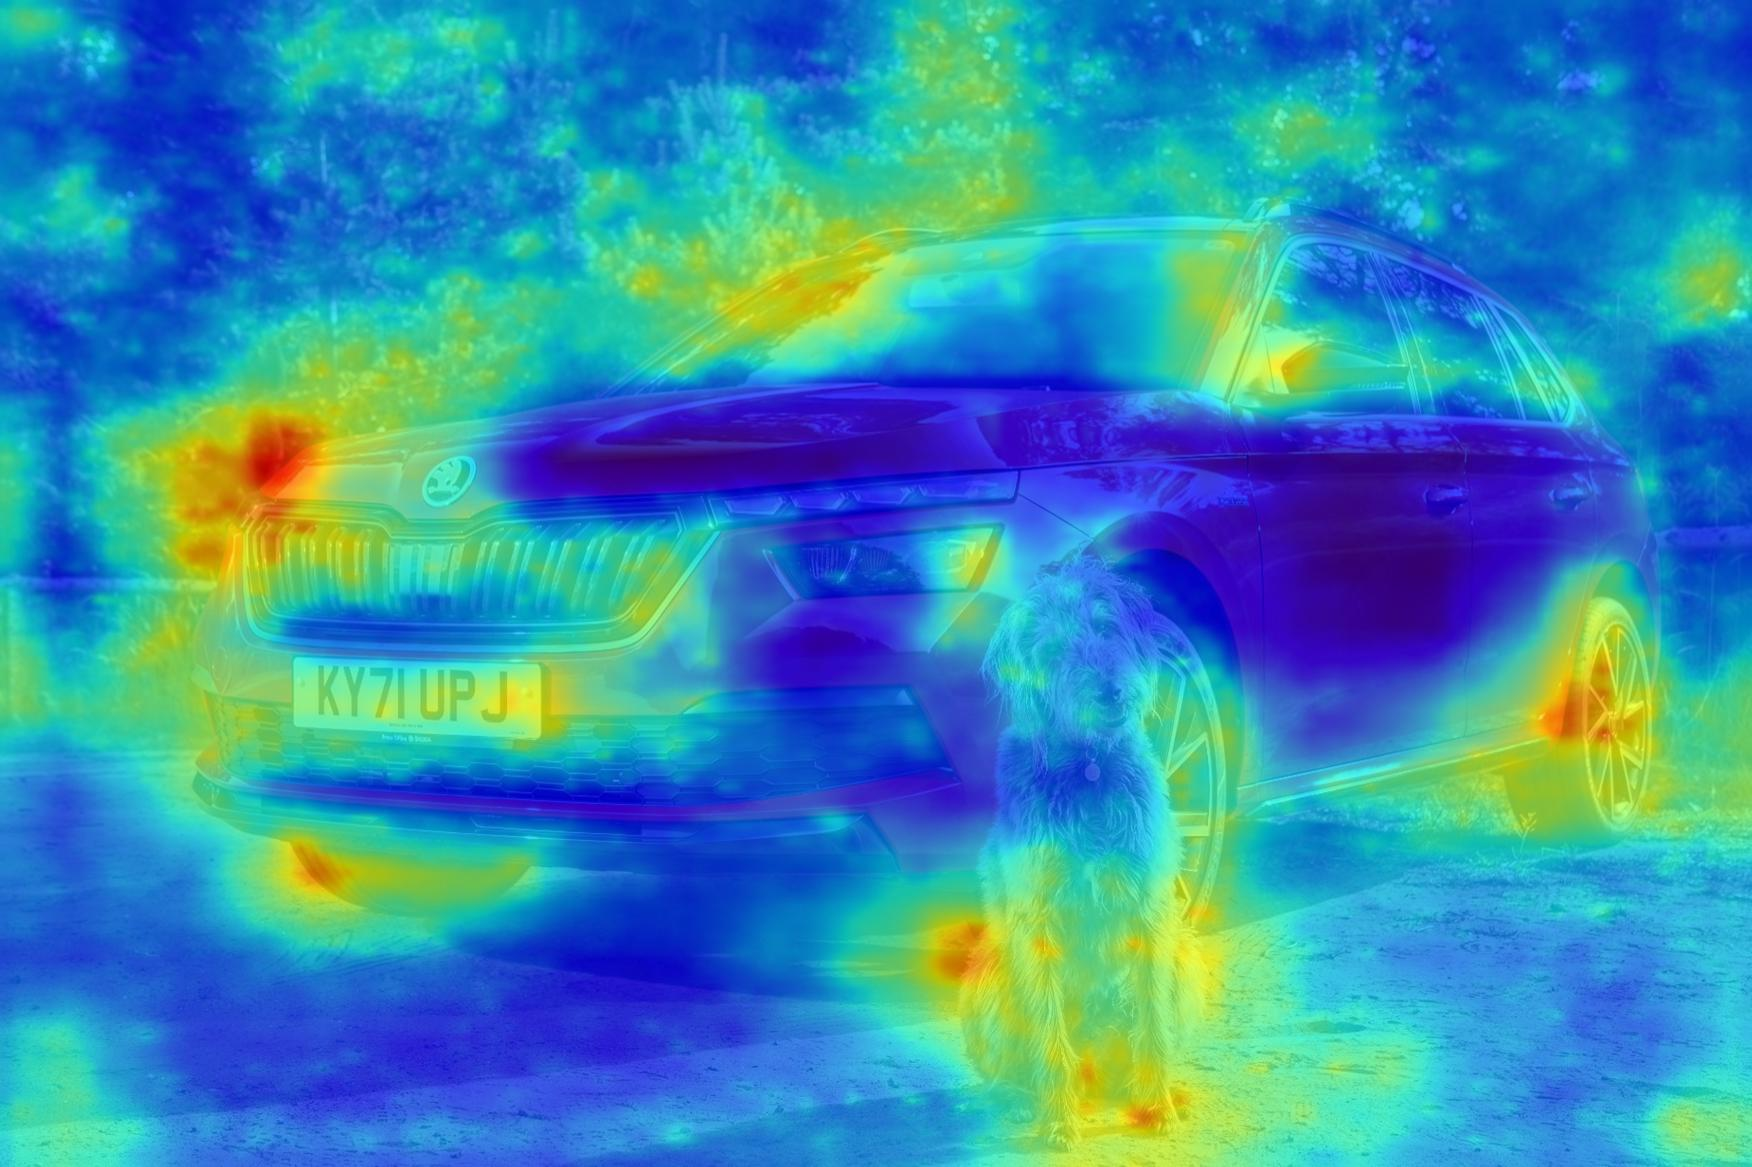

In [10]:
# heatmap = make_multi_gradcam_heatmap(img_array, model, conv_layers[-5:], pred_index=282)
heatmap = make_multi_gradcam_heatmap(img_array, model, conv_layers, pred_index=282)
# 
save_and_display_gradcam(img_path, heatmap)